In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2024-02-23 11:02:47.923445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 11:02:47.923494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 11:02:47.923529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 11:02:47.932356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 11:02:49.005837: W tensorflow/compiler/

2.14.0
CPU times: user 3.65 s, sys: 6.45 s, total: 10.1 s
Wall time: 3.01 s


In [2]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/MT-LIFT/train.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [4]:
%%time

sample = 1.0
random_state=20220720
df_criteo=df_criteo_ori[(df_criteo_ori['treatment'] == 0) | (df_criteo_ori['treatment'] == 3)].sample(frac=sample, random_state=random_state).reset_index(drop=True)
# Change 'treatment' from 3 to 1 in df_criteo_ori
df_criteo['treatment'] = df_criteo['treatment'].replace(3, 1)

# X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

# X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
# X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
# X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
# X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
# X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
# X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
# X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
# X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
# X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
# X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
# X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
# X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))
# # 
columns = [f'f{i}' for i in range(99) if not (80 <= i <= 82)] 
X = df_criteo[columns].values
# 
for i in range(X.shape[1]):
    # 
    if i not in [80, 81, 82]:
        X[:, i] = scaling(X[:, i], min=np.min(X[:, i]), max=np.max(X[:, i]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['click'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
condition_cali = (X_cali[:, 2] > 0.3) & (X_cali[:, 3] < 0.7) & (X_cali[:, 8] > 0.6) & (X_cali[:, 5] > 0.85)
X_cali = X_cali[condition_cali]
T_cali = T_cali[condition_cali]
Y_visit_cali = Y_visit_cali[condition_cali]
Y_conv_cali = Y_conv_cali[condition_cali]

condition_test = (X_test[:, 2] > 0.3) & (X_test[:, 3] < 0.7) & (X_test[:, 8] > 0.6) & (X_test[:, 5] > 0.85)
X_test = X_test[condition_test]
T_test = T_test[condition_test]
Y_visit_test = Y_visit_test[condition_test]
Y_conv_test = Y_conv_test[condition_test]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

2041521 (2041521, 96) (729116, 96) 2916459 (145822, 96)
2041521 (2041521, 96) (24535, 96) 2916459 (5002, 96)
CPU times: user 7.51 s, sys: 4.41 s, total: 11.9 s
Wall time: 11.9 s


In [5]:
count = 1

In [6]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve



# TPM-CF method:

### Train model and predict

iteration =  1


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   15.6s
[Parallel(n_jobs=32)]: Done 256 out of 256 | elapsed:   21.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    5.2s
[Parallel(n_jobs=32)]: Done 256 out of 256 | elapsed:    9.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 256 out of 256 | elapsed:    1.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 256 out of 256 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   15

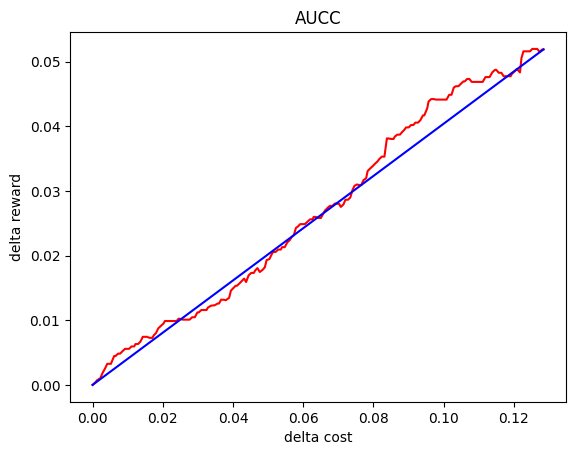

delta_cost  delta_reward  n_treatment  n_control  roi_pred_treatment  \
0      0.000000      0.000000            0          0            0.000000   
1      0.000743      0.000372            5          8            0.676097   
2      0.001328      0.000743           21         15            0.667720   
3      0.002205      0.001036           33         28            0.661914   
4      0.002789      0.001779           43         35            0.657292   
..          ...           ...          ...        ...                 ...   
196    0.125977      0.051947         2664       2211            0.390626   
197    0.126641      0.051947         2674       2212            0.389743   
198    0.127305      0.051496         2680       2214            0.389212   
199    0.128049      0.051868         2687       2215            0.388592   
200    0.128421      0.051868         2690       2216            0.388327   

     roi_pred_control  
0            0.000000  
1            0.675489  
2            0.671756  
3            0.663486  
4            0.659372  
..                ...  
196          0.390673  
197          0.390566  
198          0.390351  
199          0.390243  
200          0.390135  

[201 rows x 6 columns]

AUCC =  0.5202167025448591


In [10]:
import sklearn 
import sklearn.metrics
from metric.Metric import *
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
import pickle

grf_aucc_list = []

X_grf_train = X_train
T_grf_train = T_train.flatten()
Y_visit_grf_train = Y_visit_train.flatten()
Y_conv_grf_train = Y_conv_train.flatten()

X_grf_test = X_test
T_grf_test = T_test.flatten()
Y_visit_grf_test = Y_visit_test.flatten()
Y_conv_grf_test = Y_conv_test.flatten()

for i in range(count):
    
    print("iteration = ", i + 1)
    
    depth = 6
    min_samples_leaf = 1000
    n_estimators = 256

    grf_random_state = 20220723 + i * 11
    
    # visit
    est_it = CausalForestDML(model_y=RandomForestClassifier(n_estimators=150, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=150, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=32,
                          max_depth=depth,
                          verbose=1,
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Y_visit_grf_train, T_grf_train, X=X_grf_train, cache_values=True)
    
    model_file = "../model_file/uplift/criteo/final_model/grf/A_visit_CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    grf_test_pre_visit = est_it.effect(X_grf_test)
    
    # conv
    est_it = CausalForestDML(model_y=RandomForestClassifier(n_estimators=50, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=50, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=32,
                          max_depth=depth,
                          verbose=1,   
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Y_conv_grf_train, T_grf_train, X=X_grf_train, cache_values=True)
    
    model_file = "../model_file/uplift/criteo/final_model/grf/A_conv_CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    grf_test_pre_conv = est_it.effect(X_grf_test)
    
    # roi
    
    roi_grf_pre = grf_test_pre_conv / np.where(abs(grf_test_pre_visit) < 1e-6, 1e-6, grf_test_pre_visit)


    grf_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_grf_pre.flatten(), quantile=200)

    grf_aucc_list.append(grf_aucc)

In [11]:
A_grf_aucc_list = get_aucc_cost_curve(grf_aucc_list)
print("aucc = ", np.sum(A_grf_aucc_list['delta_reward'].values) / (A_grf_aucc_list['delta_reward'].values[-1] * 201))
A_grf_aucc_list.to_csv("../figure/mt/b_grf_aucc_list.csv")

aucc =  0.5202167025448591
